In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,832 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/uni

In [10]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [13]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [90]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"}
collect_steps_per_iteration =   4 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment


In [15]:
env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)

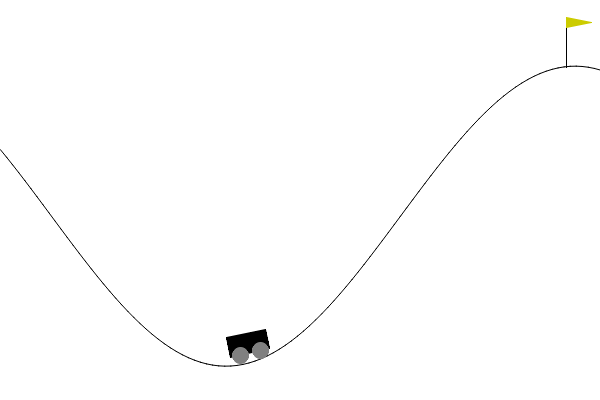

In [16]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [20]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])


In [18]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [21]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In the MountainCar-v0 environment:

-   `observation` is an array of 2 floats: 
    -   the position and velocity of the cart
-   `reward` is a scalar float value
-   `action` is a scalar integer with three possible values:
    -   `0` — "Push to the left"
    -   `1` — "Don't push"
    -   `2` — "Push to the right"


Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.50401306,  0.        ], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(-1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.5031599 ,  0.00085319], dtype=float32)})


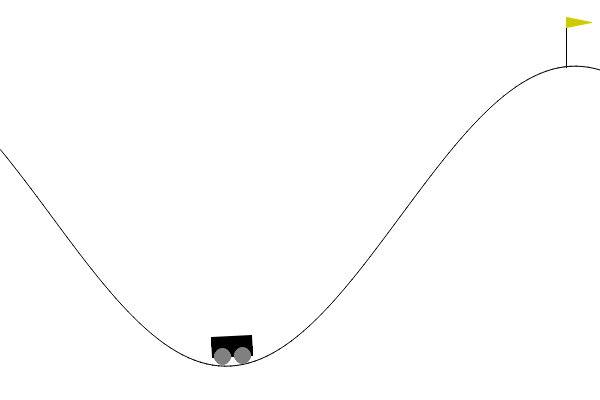

In [52]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(2, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

PIL.Image.fromarray(env.render())

In [53]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [55]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [56]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

In [68]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Metrics and Evaluation

In [60]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [62]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-200.0

## Replay Buffer

In [63]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpvienuj3e.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpvienuj3e
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44907
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


## Data Collection

In [69]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.5109196 , -0.00110334], dtype=float32)}),
 ())

In [70]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
iter(replay_buffer.as_dataset()).next()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.55314785, -0.00762144],
        [-0.55954796, -0.00640011]], dtype=float32)>,
  'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>,
  'policy_info': (),
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1., -1.], dtype=float32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([1269333622777337291, 1269333622777337291], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00250627, 0.00250627])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([399, 399])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>, times_sample

In [71]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 2), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [72]:
iterator = iter(dataset)
print(iterator)

In [73]:


iterator.next()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (48) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'step_type': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 1],
        [1, 1

## Training the agent

In [91]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 0.5282876491546631
step = 400: loss = 0.8233436346054077
step = 600: loss = 0.350292444229126
step = 800: loss = 0.4190210998058319
step = 1000: loss = 0.6131511330604553
step = 1000: Average Return = -99.19999694824219
step = 1200: loss = 0.8504230976104736
step = 1400: loss = 0.6196721196174622
step = 1600: loss = 0.655144214630127
step = 1800: loss = 0.8960299491882324
step = 2000: loss = 0.28530335426330566
step = 2000: Average Return = -125.80000305175781
step = 2200: loss = 0.349365234375
step = 2400: loss = 0.35723876953125
step = 2600: loss = 0.6221886873245239
step = 2800: loss = 0.2737237215042114
step = 3000: loss = 0.3896385431289673
step = 3000: Average Return = -112.0999984741211
step = 3200: loss = 0.5223584771156311
step = 3400: loss = 0.3923664689064026
step = 3600: loss = 0.28137442469596863
step = 3800: loss = 1.655464768409729
step = 4000: loss = 2.6400370597839355
step = 4000: Average Return = -191.0
step = 4200: loss = 1.786855936050415
step = 4

## Visualization


(-205.04000015258788, 250.0)

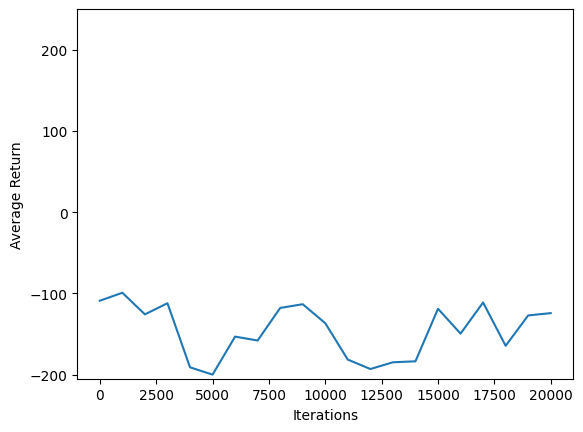

In [92]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [93]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [94]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x5c97d93c9a40] Warning: data is not aligned! This can lead to a speed loss


In [95]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x581cf7d33a40] Warning: data is not aligned! This can lead to a speed loss
